In [1]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
# from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [2]:
# Specify the Mean and standard deviation of all the pixels in the MNIST dataset. They are precomputed
mean_gray = 0.1307
stddev_gray = 0.3081

#Transform the images to tensors
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn)
#for n channels, this transform will normalize each channel of the input torch.Tensor
#i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]

transforms_ori = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray,), (stddev_gray,))])

transforms_photo = transforms.Compose([transforms.Resize((28,28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean_gray,), (stddev_gray,))])

#Load our dataset
train_dataset = datasets.MNIST(root = './data',
                            train = True,
                            transform = transforms_ori,
                            download = True)

test_dataset = datasets.MNIST(root = './data',
                            train = False,
                            transform = transforms_ori)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 22.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 632kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 5.51MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.82MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



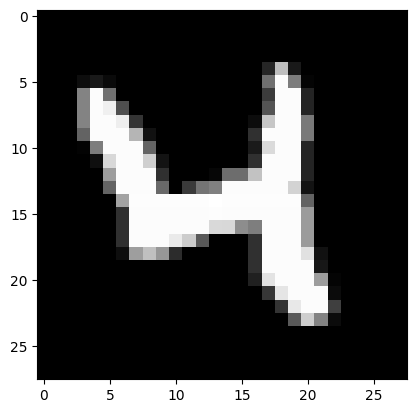

In [3]:
import matplotlib.pyplot as plt
random_image = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28, 28), cmap='gray')

In [4]:
print(train_dataset[20][1])   #Print the corresponding label for the image

4


In [5]:
batch_size = 100
epochs = 10

In [6]:
#Make the dataset iterable
train_load = torch.utils.data.DataLoader(dataset = train_dataset,
                                         batch_size = batch_size,
                                         shuffle = True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False)

In [7]:
print('There are {} images in the training set'.format(len(train_dataset)))
print('There are {} images in the test set'.format(len(test_dataset)))
print('There are {} batches in the train loader'.format(len(train_load)))
print('There are {} batches in the testloader'.format(len(test_load)))

There are 60000 images in the training set
There are 10000 images in the test set
There are 600 batches in the train loader
There are 100 batches in the testloader


In [8]:
#Create the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #Same Padding = [(filter size - 1) / 2] (Same Padding--> input size = output size)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,stride=1, padding=1)
        #The output size of each of the 8 feature maps is
        #[(input_size - filter_size + 2(padding) / stride) +1] --> [(28-3+2(1)/1)+1] = 28 (padding type is same)
        #Batch normalization
        self.batchnorm1 = nn.BatchNorm2d(8)
        #RELU
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is now 28/2 = 14
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        #Output size of each of the 32 feature maps remains 14
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is 14/2 = 7
        #Flatten the feature maps. You have 32 feature maps, each of them is of size 7x7 --> 32*7*7 = 1568
        self.fc1 = nn.Linear(in_features=1568, out_features=600)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        #Now we have to flatten the output. This is where we apply the feed forward neural network as learned before!
        #It will take the shape (batch_size, 1568) = (100, 1568)
        out = out.view(-1,1568)
        #Then we forward through our fully connected layer
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        return out

In [9]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [11]:
#Understand what's happening
iteration = 0
correct_nodata = 0
correct_data = 0
for i,(inputs,labels) in enumerate (train_load):
    if iteration==1:
        break
    # inputs = Variable(inputs)
    # labels = Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    output = model(inputs)
    print("Outputs Shape",output.shape)
    _, predicted_nodata = torch.max(output, 1)
    print("Predicted Shape",predicted_nodata.shape)
    print("Predicted Tensor:")
    print(predicted_nodata)
    correct_nodata += (predicted_nodata == labels).sum()
    print("Correct Predictions: ",correct_nodata)
    _, predicted_data = torch.max(output.data, 1)
    correct_data += (predicted_data == labels.data).sum()
    print("Correct Predictions:",correct_data)


    iteration += 1

For one iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Outputs Shape torch.Size([100, 10])
Predicted Shape torch.Size([100])
Predicted Tensor:
tensor([5, 2, 6, 9, 2, 5, 7, 7, 7, 8, 7, 2, 7, 2, 2, 6, 9, 7, 7, 8, 8, 7, 2, 5,
        9, 6, 7, 5, 6, 3, 9, 7, 7, 6, 2, 8, 9, 0, 6, 5, 7, 7, 2, 6, 8, 1, 7, 5,
        2, 2, 9, 3, 7, 2, 0, 6, 7, 7, 2, 7, 2, 7, 7, 6, 9, 8, 5, 7, 5, 2, 7, 7,
        5, 5, 7, 2, 5, 6, 2, 5, 7, 9, 6, 7, 6, 8, 8, 7, 7, 0, 7, 7, 7, 6, 7, 3,
        4, 6, 5, 3])
Correct Predictions:  tensor(8)
Correct Predictions: tensor(8)


In [12]:
#Training the CNN
num_epochs = 10

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs):
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0

    model.train()                   # Put the network into training mode

    for i, (inputs, labels) in enumerate(train_load):

        # # Convert torch tensor to Variable
        # inputs = Variable(inputs)
        # labels = Variable(labels)

        # If we have GPU, shift the data to GPU
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()       # Accumulate the loss
        loss.backward()                 # Backpropagation
        optimizer.step()                # Update the weights

        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1

    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))

    #Testing
    testing_loss  = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluation mode

    for i, (inputs, labels) in enumerate(test_load):

        # # Convert torch tensor to Variable
        # inputs = Variable(inputs)
        # labels = Variable(labels)

        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels) # Calculate the loss
        testing_loss  += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()

        iterations += 1

    # Record the Testing loss
    test_loss.append(testing_loss /iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))

    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1],
             test_loss[-1], test_accuracy[-1]))

Epoch 1/10, Training Loss: 0.451, Training Accuracy: 88.170, Testing Loss: 0.144, Testing Acc: 95.980
Epoch 2/10, Training Loss: 0.155, Training Accuracy: 95.528, Testing Loss: 0.096, Testing Acc: 97.310
Epoch 3/10, Training Loss: 0.115, Training Accuracy: 96.757, Testing Loss: 0.075, Testing Acc: 97.800
Epoch 4/10, Training Loss: 0.093, Training Accuracy: 97.258, Testing Loss: 0.063, Testing Acc: 98.140
Epoch 5/10, Training Loss: 0.080, Training Accuracy: 97.645, Testing Loss: 0.055, Testing Acc: 98.370
Epoch 6/10, Training Loss: 0.071, Training Accuracy: 97.950, Testing Loss: 0.051, Testing Acc: 98.430
Epoch 7/10, Training Loss: 0.064, Training Accuracy: 98.135, Testing Loss: 0.046, Testing Acc: 98.570
Epoch 8/10, Training Loss: 0.057, Training Accuracy: 98.298, Testing Loss: 0.042, Testing Acc: 98.700
Epoch 9/10, Training Loss: 0.053, Training Accuracy: 98.410, Testing Loss: 0.040, Testing Acc: 98.680
Epoch 10/10, Training Loss: 0.051, Training Accuracy: 98.520, Testing Loss: 0.039,

In [13]:
#Run this if you want to save the model
torch.save(model.state_dict(),'CNN_MNIST.pth')

```python
# 如果你想保存模型，请运行此代码
torch.save(model.state_dict(), 'CNN_MNIST.pth')

# 如果你想加载模型，请运行此代码
model.load_state_dict(torch.load('CNN_MNIST.pth'))
```

### 代码逐行解释：
1. `torch.save(model.state_dict(), 'CNN_MNIST.pth')`：
   - **功能**：保存模型的状态字典（包含模型的所有参数）。
   - **参数**：
     - `model.state_dict()`：模型的状态字典。
     - `'CNN_MNIST.pth'`：保存文件的路径和文件名。
  - **保存模型**：
    - `torch.save(model.state_dict(), 'CNN_MNIST.pth')`：将模型的状态字典保存到文件`CNN_MNIST.pth`中。状态字典包含了模型的所有参数（权重和偏置），可以用于之后的模型恢复。

2. `model.load_state_dict(torch.load('CNN_MNIST.pth'))`：
   - **功能**：加载保存的模型状态字典。
   - **参数**：
     - `torch.load('CNN_MNIST.pth')`：加载保存的状态字典。
     - `model.load_state_dict(...)`：将加载的状态字典应用到模型中。
  - **加载模型**：
    - `model.load_state_dict(torch.load('CNN_MNIST.pth'))`：从文件`CNN_MNIST.pth`中加载模型的状态字典，并将其应用到当前模型实例中。这一步可以恢复之前保存的模型参数，使得模型可以继续进行训练或进行推理。

In [14]:
test_loss

[0.14364497513510288,
 0.09579364559147507,
 0.07528841709252447,
 0.06316123359836638,
 0.054718225655378774,
 0.05066403197706677,
 0.046440044816117736,
 0.04201344131026417,
 0.03968645030923654,
 0.0391327102977084]

In [15]:
test_accuracy

[tensor(95.9800),
 tensor(97.3100),
 tensor(97.8000),
 tensor(98.1400),
 tensor(98.3700),
 tensor(98.4300),
 tensor(98.5700),
 tensor(98.7000),
 tensor(98.6800),
 tensor(98.7800)]

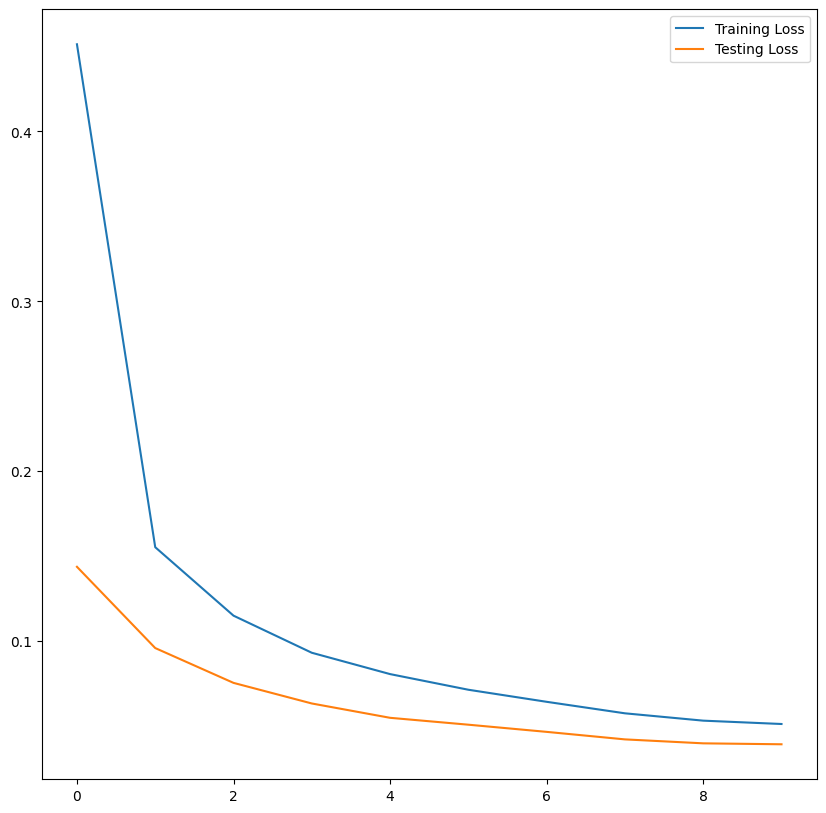

In [16]:
# Loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

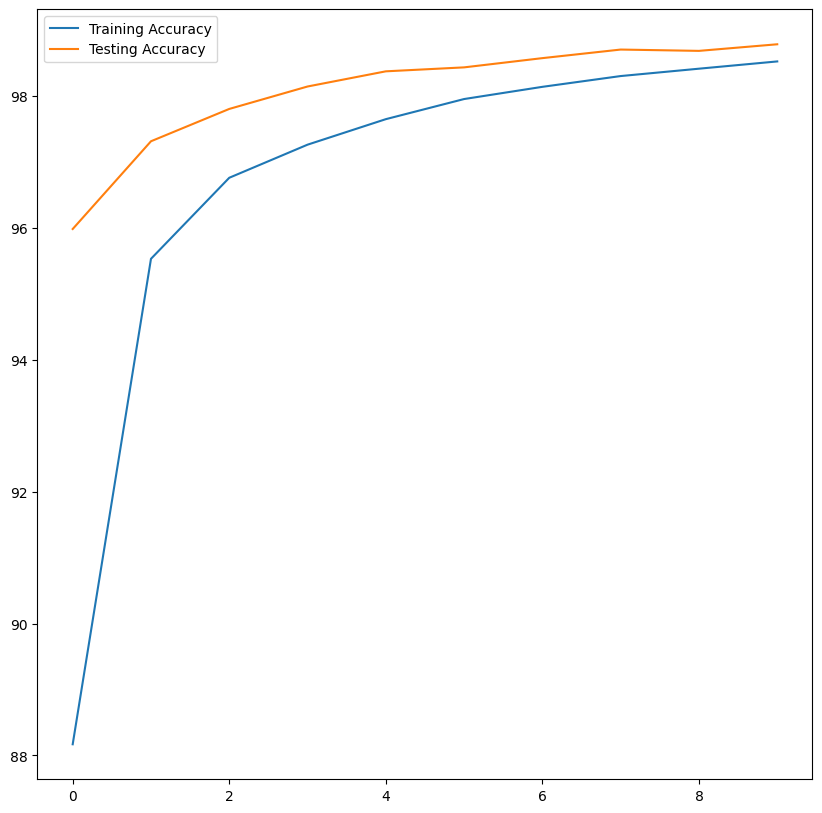

In [17]:
# Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

In [18]:
#Run this if you want to load the model
model.load_state_dict(torch.load('CNN_MNIST.pth'))

<ipython-input-18-0c95fb8960a2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('CNN_MNIST.pth'))


<All keys matched successfully>

In [19]:
from google.colab.patches import cv2_imshow
#Predict your own image
def predict(img_name,model):
    image = cv2.imread(img_name,0)   #Read the image
    ret, thresholded = cv2.threshold(image,127,255,cv2.THRESH_BINARY)   #Threshold the image
    img = 255-thresholded           #Apply image negative
    # cv2.imshow('Original',img)      #Display the processed image
    cv2_imshow(img) # change to this one due to cv2.imshow cannot work well in google clob
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    img = Image.fromarray(img)      #Convert the image to an array
    img = transforms_photo(img)     #Apply the transformations
    img = img.view(1,1,28,28)       #Add batch size
    # img = Variable(img)             #Wrap the tensor to a variable 在较新的 PyTorch 版本中，Variable 类已经被弃用，直接使用张量即可。因此，img = Variable(img) 这一步是不必要的，可以直接使用张量进行前向传播和其他操作。

    model.eval()

    if torch.cuda.is_available():
        model = model.cuda()
        img = img.cuda()

    output = model(img)
    print(output)
    print(output.data)
    _, predicted = torch.max(output,1)
    return  predicted.item()

### 代码逐行解释：
1. `from google.colab.patches import cv2_imshow`：导入`cv2_imshow`函数，用于在Google Colab中显示图像。
2. `import cv2`：导入OpenCV库，用于图像处理。
3. `from PIL import Image`：导入PIL库，用于图像转换。
4. `import torch`：导入PyTorch库。
5. `from torch.autograd import Variable`：导入`Variable`类，用于包装张量。

6. `def predict(img_name, model):`：定义预测函数，接受图像文件名和模型作为参数。
7. `image = cv2.imread(img_name, 0)`：读取图像，`0`表示以灰度图像读取。
8. `ret, thresholded = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)`：对图像进行二值化处理，阈值为127，最大值为255。
9. `img = 255 - thresholded`：应用图像负片效果。
10. `cv2_imshow(img)`：显示处理后的图像。
11. `cv2.waitKey(0)`：等待按键事件。
12. `cv2.destroyAllWindows()`：销毁所有窗口。
13. `img = Image.fromarray(img)`：将图像转换为数组。
14. `img = transforms_photo(img)`：应用预处理变换（假设`transforms_photo`已经定义）。
15. `img = img.view(1, 1, 28, 28)`：添加批次大小，调整图像形状为`[1, 1, 28, 28]`。
16. `img = Variable(img)`：将张量包装为变量。
17. `model.eval()`：将模型置于评估模式。
18. `if torch.cuda.is_available():`：如果有可用的CUDA设备：
    - `model = model.cuda()`：将模型移动到GPU。
    - `img = img.cuda()`：将图像移动到GPU。
19. `output = model(img)`：通过模型进行前向传播，获取输出。
20. `print(output)`：打印输出。
21. `print(output.data)`：打印输出数据。
22. `_, predicted = torch.max(output, 1)`：获取预测结果，`torch.max`返回每行的最大值及其索引，这里我们只需要索引（即预测的类别）。
23. `return predicted.item()`：返回预测结果。

### 语法检查：
代码语法正确，但需要确保导入了必要的库，并且预处理变换`transforms_photo`已经定义。

### 代码优化建议：
1. 确保导入了必要的库。
2. 可以添加注释说明预处理变换`transforms_photo`的定义。


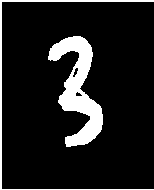

tensor([[-5.0917, -0.1535,  2.2371,  9.1931, -2.8711,  0.9719, -4.5167,  0.7383,
         -1.0631,  1.9547]], grad_fn=<AddmmBackward0>)
tensor([[-5.0917, -0.1535,  2.2371,  9.1931, -2.8711,  0.9719, -4.5167,  0.7383,
         -1.0631,  1.9547]])
The Predicted Label is 3


In [20]:
pred = predict('3.jpg', model)
print("The Predicted Label is {}".format(pred))